# Percent Displacement Calculation for Displaced Fractures
Operates on output of Unet CNN

### Imports

In [40]:
import sys
import os
import gzip
import matplotlib.pyplot as plt
from tqdm import tqdm
import queue
import random

# torch + numerical imports
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader, Subset

# image preprocessing
import cv2 as cv 
from skimage.filters import unsharp_mask

# clustering
from sklearn.cluster import KMeans

# linear regression
from sklearn.linear_model import LinearRegression

sys.path.insert(0, '../')
from src.rfc_dataset import RFCDataset

from time import sleep
%matplotlib notebook

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Import data

In [4]:
data = RFCDataset(
    data_dir="../data/ribfrac-challenge/training/prepared/pos",
)

Let's take a look at one particular fracture. A quick search through data above shows that these are a set of 2D slices that have a fracture in them.

In [5]:
# sorted([path for path in data.paths if 'RibFrac100' in str(path)])
slice_nums = list(range(156, 171))
str_paths = [str(path) for path in data.paths]

pre = '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_'
nums = []
for s in str_paths:
    if pre in s:
        num = int(s[len(pre) : s.find('.', len(pre))])
        nums.append(num)
nums = sorted(nums)

In [6]:
subset = list(range(186, 200 + 1)) # select only a few of nums if you care.
str_targets = [pre + str(i) + '.pt.gz' for i in subset]
fx_inds = [i for i, path in enumerate(str_paths) if path in str_targets]

In [7]:
size = len(subset)
slices = torch.zeros((size, 512, 512))
labels = torch.zeros((size, 512, 512))
for i, ind in enumerate(tqdm(fx_inds)):
    ds = data.__getitem__(ind)
    slices[i, ...] = ds['image']
    labels[i, ...] = ds['label']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.52it/s]


In [8]:
num_displaced_fx = (labels == 2).sum(axis=[1, 2])
torch.tensor(subset)[num_displaced_fx != 0]

tensor([186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200])

#### We observe that slice 189 is a somewhat pathological example, and thus ignore it.

In [9]:
to_keep = [True] * size
to_keep[3] = False

In [10]:
slices = slices[to_keep, ...]
labels = labels[to_keep, ...]

Here, we save our output for this set of slices to gain some intuition on each fracture.

In [11]:
def save_slices(arr, name):
    for i in tqdm(range(arr.shape[0])):
        fig = plt.figure()
        plt.imshow(slices[i, ...])
        plt.colorbar()
#         fig.savefig(f'./fracture_examples/{name}_{i}.png', dpi=400)
        
# save_slices(slices, 'slices')
# save_slices(labels, 'labels')

<IPython.core.display.Javascript object>


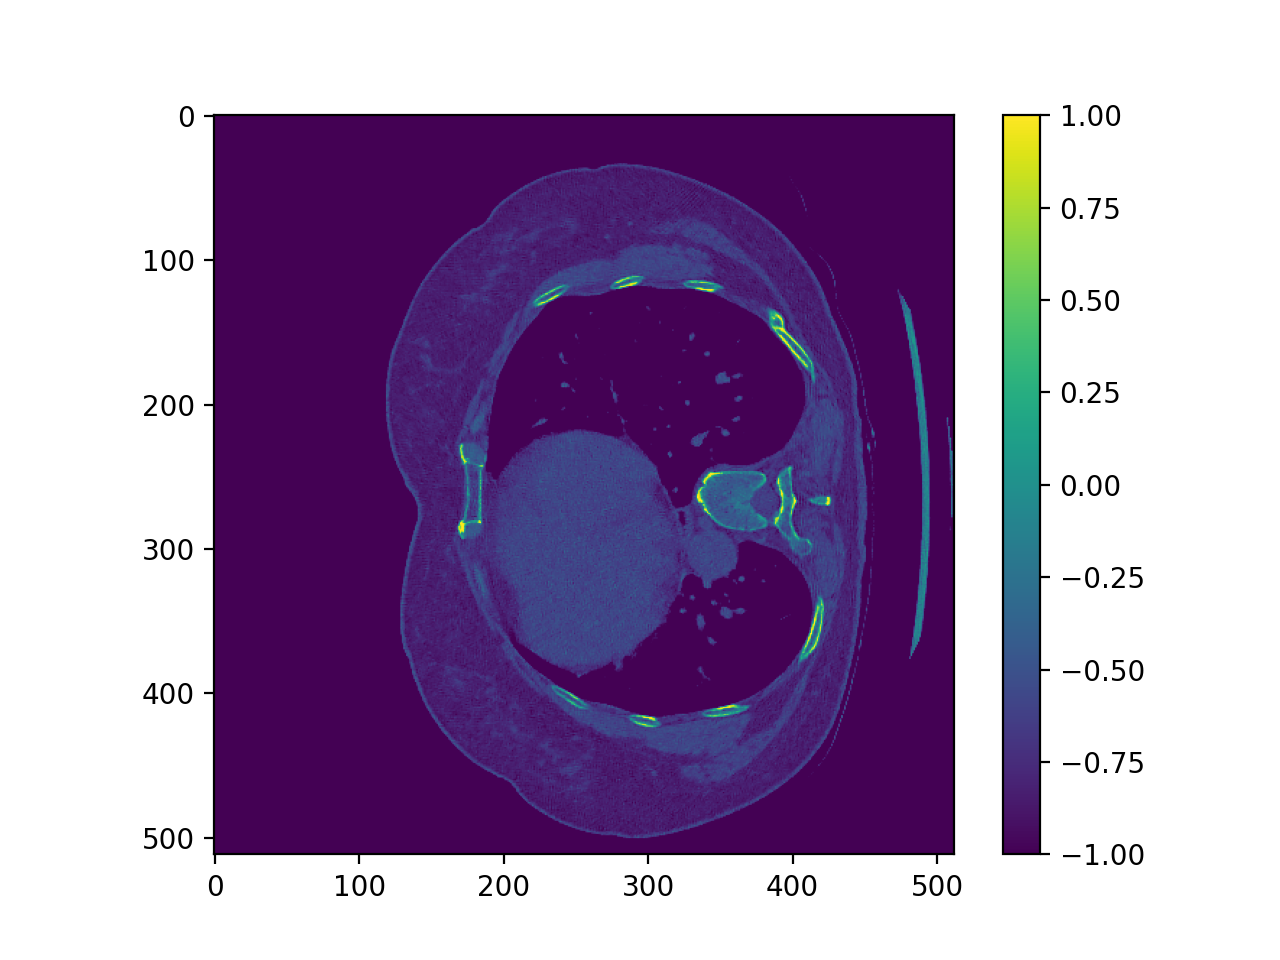

In [12]:
plt.figure()
plt.imshow(slices[4, ...])
plt.colorbar()

<IPython.core.display.Javascript object>


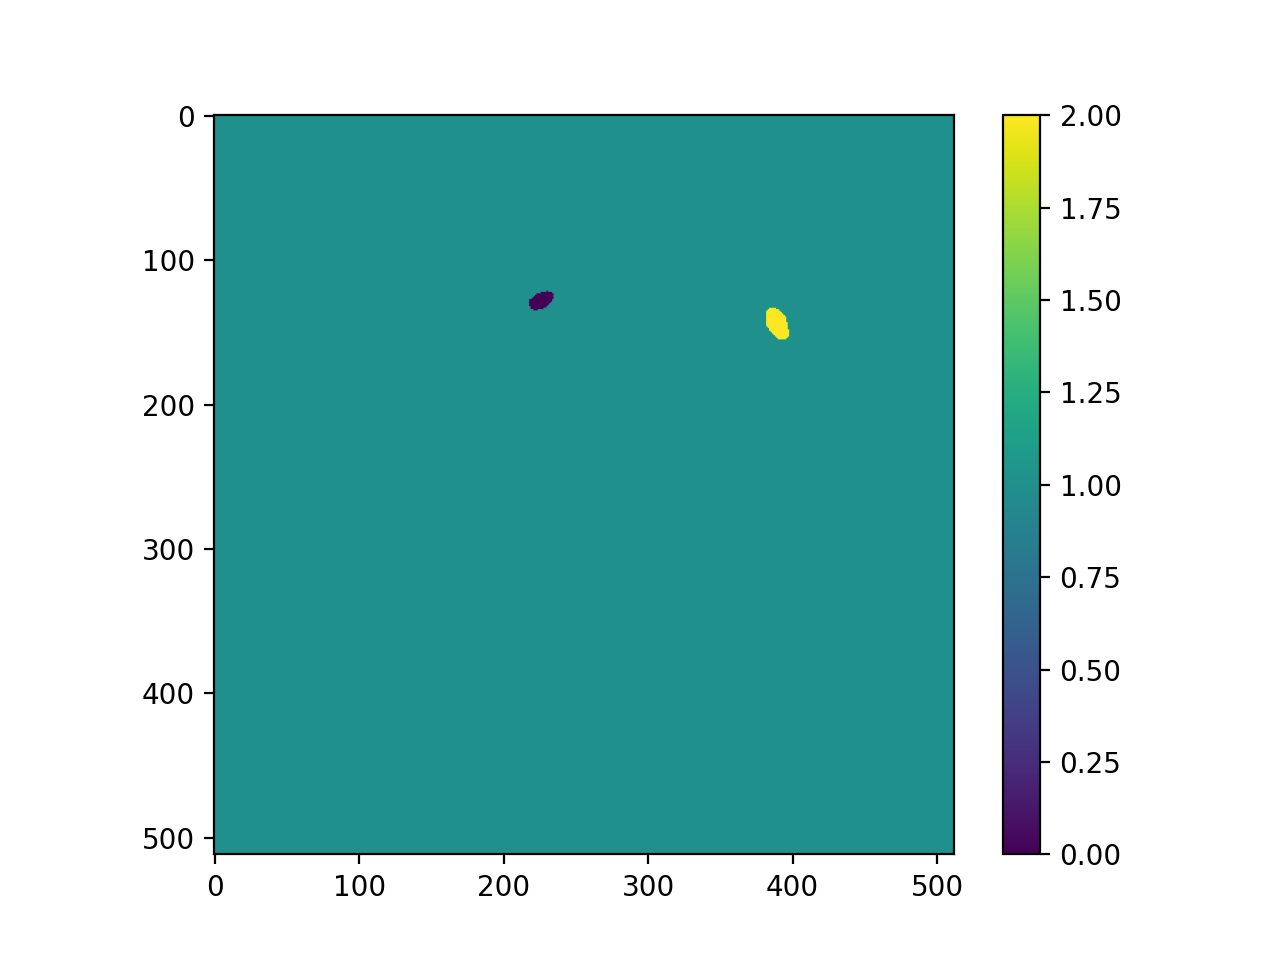

In [13]:
plt.figure()
plt.imshow(labels[4, ...])
plt.colorbar()

For now, let's assume there's only one displaced fracture per CT scan. We'll beef this up if the algorithm works!

## The Algorithm


### Transforms and Masking

In [14]:
# only consider displaced fractures.
mask = labels == 2
box_rad = 25
nz = mask.nonzero()
bb_x_max, bb_x_min = max(nz[:, 1]), min(nz[:, 1]) 
bb_y_max, bb_y_min = max(nz[:, 2]), min(nz[:, 2]) 

mask[
    :, 
    bb_x_min - box_rad : bb_x_max + box_rad,
    bb_y_min - box_rad : bb_y_max + box_rad,
] = 1

#### Mask out all pixels outside bounding box

In [15]:
# all pictures outside region to be included
non_included = (mask == 0)
rest_slices = slices.clone()
rest_slices[non_included] = -1

#### Set all pixels with less than a certain magnitude to background pixels

In [16]:
# highpass filter (get rid of background)
rest_slices[rest_slices < -0.25] = -1

<IPython.core.display.Javascript object>


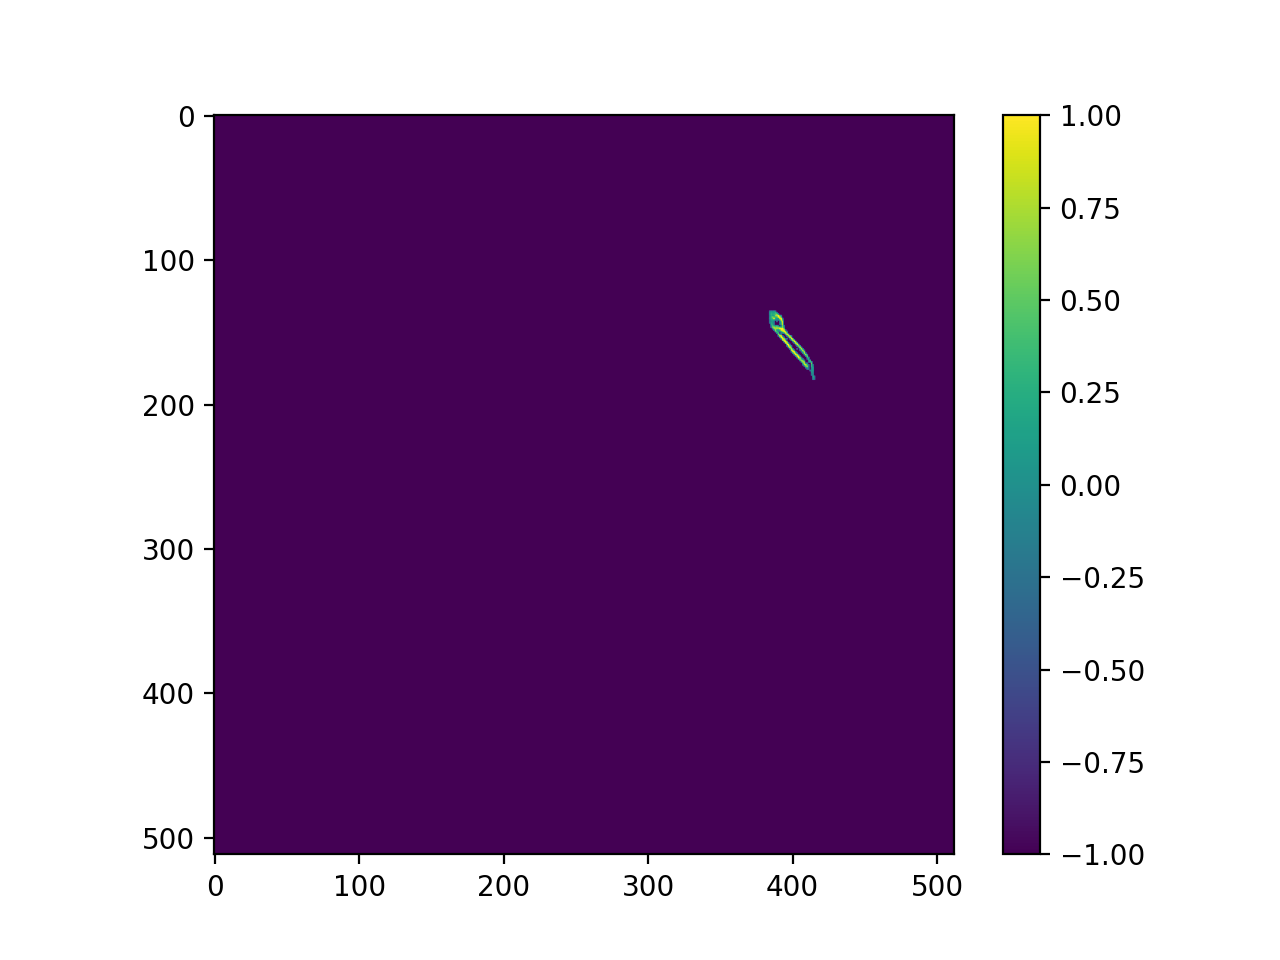

In [17]:
plt.figure()
plt.imshow(rest_slices[4, ...])
plt.colorbar()

#### Sharpen image
The image below is sharpened and zoomed in. Previously, we used `unsharp_mask`: 
(`result_3 = unsharp_mask(rest_slices[4, ...], radius=2, amount=30)`). 
Instead, we can do something simpler: set all pixels with values less than a threshold to the background pixel value!

<IPython.core.display.Javascript object>


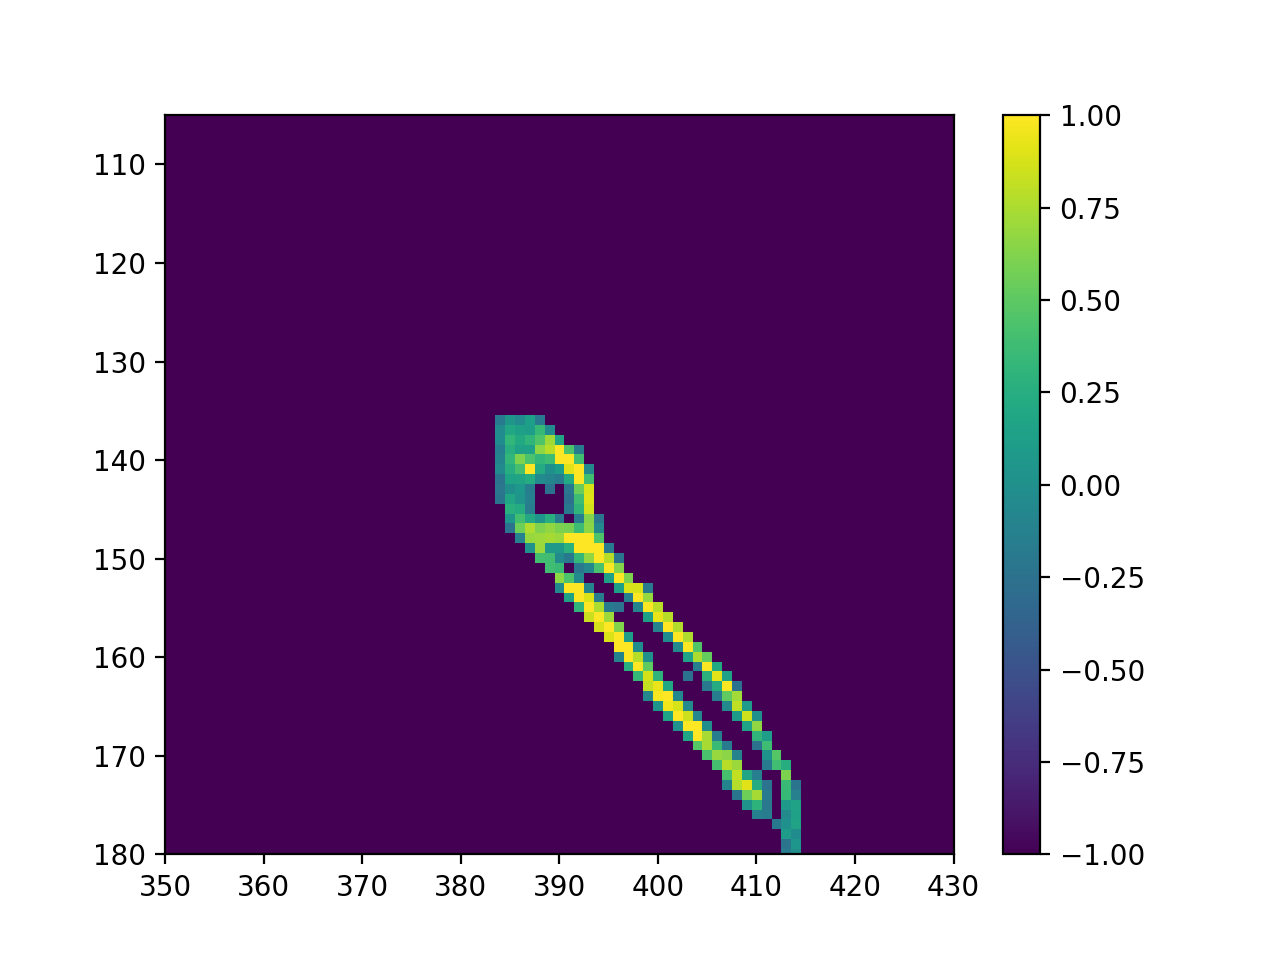

In [18]:
threshold = -.3
sharpened = np.zeros_like(rest_slices)
for i in range(rest_slices.shape[0]):
    img = rest_slices[i, ...].clone()
    img[img <= threshold] = -1
    sharpened[i, ...] = img
    
plt.figure()
plt.imshow(sharpened[4, ...])
plt.xlim(350, 430)
plt.ylim(180, 105)
plt.colorbar()

### BFS Hole Detection
We see in the picture above that the area within cross sectional slices of bones are represented by "holes," or regions in the picture completely surrounded by boundaries. This is a monte-carlo (BFS) method to find such groupings. 

In [19]:
def in_bounds(row, col, H, W):
    return row >= 0 and col >= 0 and row < H and col < W

In [20]:
def safe_access(img, row, col):
    if in_bounds(row, col, img.shape[0], img.shape[1]):
        return True, img[row][col]
    else:
        return False, 0

def explore_neighbors(img, row, col, queue, tracking_bg, bg_pixel_value=-1):
    # increments to a pixel's row and col values to find the neighboring pixels
    incr = [-1, 0, 1]
    
    # shape (for checking bounds)
    H, W = img.shape
    
    # add in-bounds pixels to the queue to explore.    
    for row_incr in incr:
        for col_incr in incr:
            # don't add self
            if row_incr == 0 and col_incr == 0:
                continue
            
            # don't add if out of bounds
            if not in_bounds(row + row_incr, col + col_incr, H, W):
                continue
            
            # "corner" rule—don't let a background region bleed through diagonal non-boundary region.
            is_diag = row_incr != 0 or col_incr != 0
            if tracking_bg and is_diag:
                if img[row, col + col_incr] != bg_pixel_value and  \
                   img[row + row_incr, col] != bg_pixel_value:
                    continue
            
            queue.put((row + row_incr, col + col_incr))

In [21]:
def find_groupings(img, bg_pixel_value=-1): # O(img.shape[0] * img.shape[1])
    
    # indices of possible pixels to search. also serves as a "visited" array for BFS.
    remaining_indices = set([(i, j) for i in range(img.shape[0]) for j in range(img.shape[1])])
    
    # final groupings of indices to form each enclosed boundary.
    groupings = [] 
    edges = []
    
    is_bg_pred = lambda val : val == bg_pixel_value
    is_not_bg_pred = lambda val : val != bg_pixel_value
    
    while len(remaining_indices) > 0: # will repeat O(1) times
        
        # starting index of BFS search (start with finding overall background)
        if len(groupings) == 0 and len(edges) == 0:
            s_ind = (1, 1)
        else:
            s_ind = random.choice(tuple(remaining_indices)) # conversion is inefficient, but rare.
        
        # set up a predicate function so that:
        # if s_ind is the index of a non-background pixel, explore all connected pixels to find those that
        #    are also not background pixels
        # if s_ind is the index of a background pixel, explore all connected background pixels.
        s_row, s_col = s_ind
        tracking_bg = img[s_row, s_col] == bg_pixel_value
        if tracking_bg:
            pred = is_bg_pred
        else:
            pred = is_not_bg_pred
        
        # BFS around s_ind #
        grouping = []
        to_explore = queue.SimpleQueue()
        to_explore.put(s_ind)
        while len(remaining_indices) > 0 and not to_explore.empty():
            ind = to_explore.get_nowait()
            row, col = ind
            # only continue search and store current pixel if:
            # pixel hasn't been visited, and pixel is part of the group we're exploring.
            if ind in remaining_indices and pred(img[row, col]):
                # add to visited
                remaining_indices.remove(ind)
                # add to grouping
                grouping.append(ind)
                
                # add neighbors to explore (all pixels directly touching current pixel, including diagonals)
                explore_neighbors(img, row, col, to_explore, tracking_bg, bg_pixel_value)
        
        # if we're currently finding a group of connected pixels in a hole,
        # store in groupings. else, store in edges.
        if tracking_bg:
            groupings.append(grouping)
        else:
            edges.append(grouping)
        
    return groupings, edges

#### Let's make a quick test case for this code!

<IPython.core.display.Javascript object>


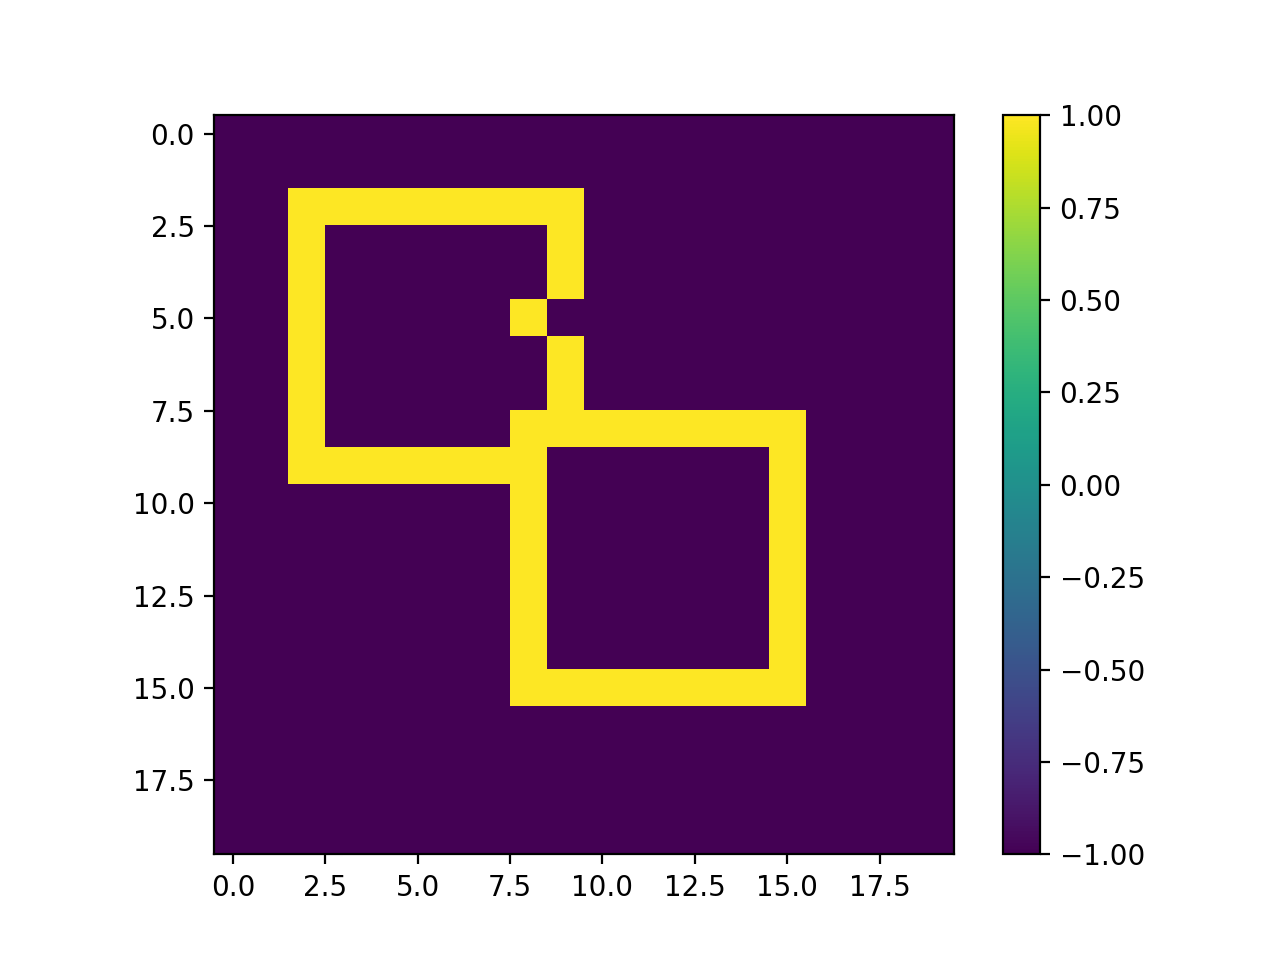

In [22]:
# let's make a test case for our code!
grouping_test = np.ones((20, 20)) * -1

# now form two holes, around c_1 and c_2:
c_1 = (6, 6)
c_2 = (12, 12)
for c in [c_1, c_2]:
    row, col = c
    grouping_test[row - 4 : row + 4, col - 4 : col + 4] = 1 # set boundary
    grouping_test[row - 3 : row + 3, col - 3 : col + 3] = -1 # set hole
    
# insert quick edge case
grouping_test[5, 9] = -1
grouping_test[5, 8] = 1

plt.figure()
plt.imshow(grouping_test)
plt.colorbar()

#### Let's visualize how our "hole detection" algorithm did on our quick test! We want this image to look like the one above, except. The only difference is that we've explored the space completely and found all of the holes (contiguous groups of background pixels) and boundaries (contiguous groups of non-background pixels)

In [23]:
def plot_groups(img):
    # get groups as per algorithm
    groups, edges = find_groupings(img)
    n_groups = len(groups)
    print(n_groups, 'groups found!')

    # some genereal heuristics
    num_bg_pix = sum([len(g) for g in groups])
    total_pix = img.shape[0] * img.shape[1]
    print(num_bg_pix, 'background pixels found amongst', total_pix, 'total pixels.')
    
    combined = []
    for g in groups:
        combined.extend(g)
    assert len(set(combined)) == num_bg_pix # no duplicates

    # color non-background pixels yellow
    groups_img = np.ones_like(img)

    # color background pixels purple
    colors = np.arange(0, 1, 1 / n_groups)
    for i, group in enumerate(groups):
        for r, c in group:
            groups_img[r, c] = colors[i]

    # display image
    plt.figure()
    plt.imshow(groups_img)
    plt.colorbar()

3 groups found!
347 background pixels found amongst 400 total pixels.


<IPython.core.display.Javascript object>


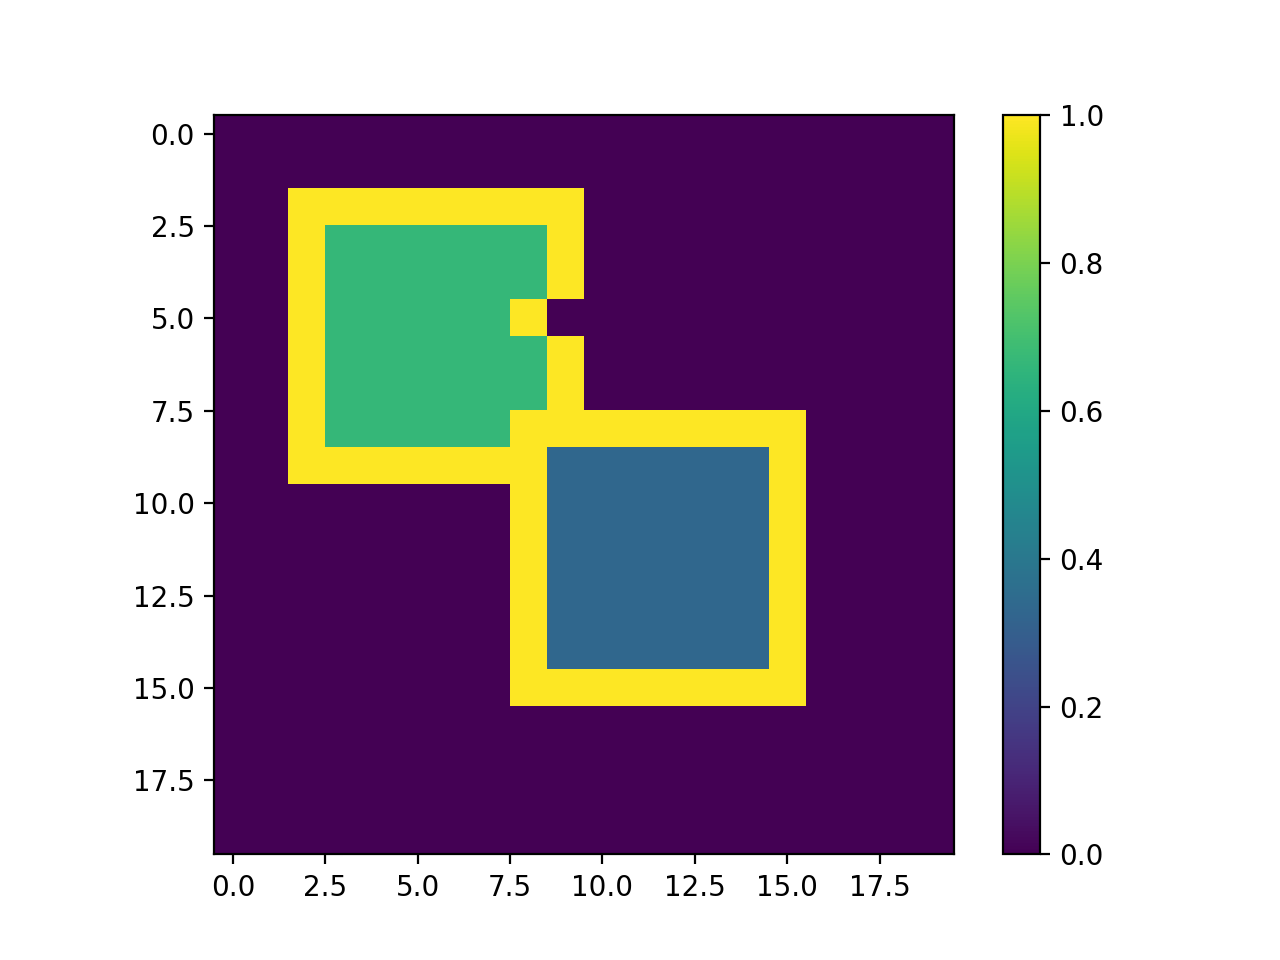

In [24]:
plot_groups(grouping_test)

#### Now that we see a clear distinction between each group, the overall background group, and the boundaries, we can try our hole detection framework on a real CT scan slice.

7 groups found!
261841 background pixels found amongst 262144 total pixels.


<IPython.core.display.Javascript object>


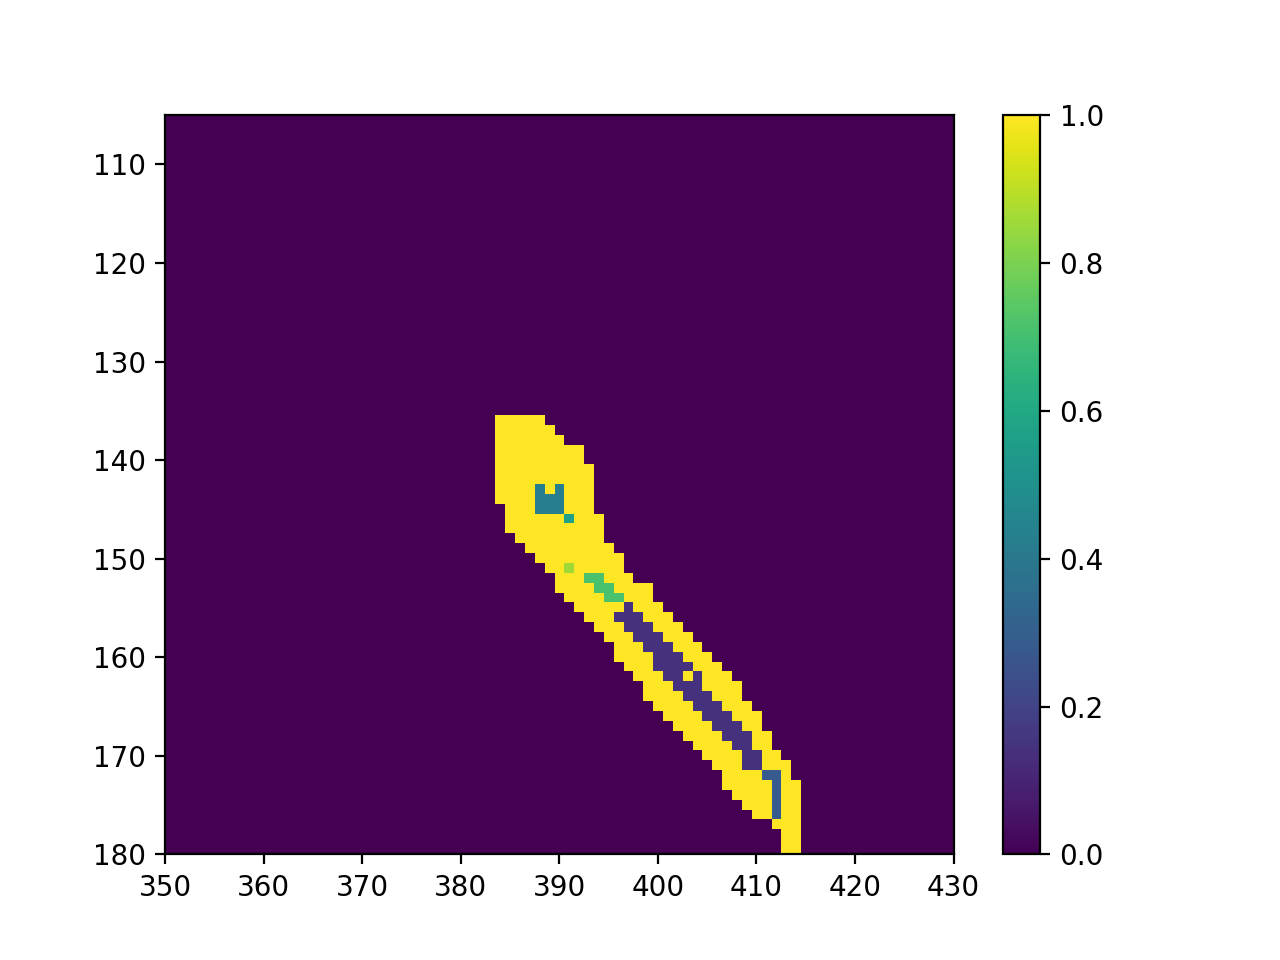

In [25]:
plot_groups(sharpened[4, ...])
plt.xlim(350, 430)
_ = plt.ylim(180, 105)

## Bone Group Axis Calculation

#### Let's now get the two largest groups within the bone boundaries for each slice. 

In [26]:
final_groups = []
num_to_consider = 1
for i in tqdm(range(sharpened.shape[0])):
    img = sharpened[i, ...]
    groups, edges = find_groupings(img)
    groups = sorted(groups, key = lambda g : len(g), reverse=True)
    bone_groups = tuple(groups[1 : 1 + num_to_consider])
#     bone_groups = groups
    final_groups.append(bone_groups)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:16<00:00,  5.47s/it]


#### Reconstruct 2D superposition of bone fragments from all slices

In [27]:
coms = []
stds = []
all_pts = []
for i, groups in enumerate(final_groups):
    for j, group in enumerate(groups):
        if j > 0:
            continue
        x_com, y_com = np.array(group).mean(axis=0)
        x_std, y_std = np.array(group).std(axis=0)
        coms.append([i, x_com, y_com])
        stds.append([i, x_std, y_std])
        for row, col in group:
            all_pts.append([i, row, col])
            
coms = np.array(coms)
stds = np.array(stds)
all_pts = np.array(all_pts)

#### Display all points to show displacement!

In [28]:
# Choosing to leave out for now. Instead of just taking the largest group, maybe
# there's a better way we could combine, say, the 3 largest groups from each slice 
# to perform better on pathological examples.

# kmeans = KMeans(n_clusters=2, random_state=0)
# preds = kmeans.fit_predict(comb[:, 1:])
# preds = preds.reshape((-1, 3))
# cluster_coms = kmeans.cluster_centers_
# print(cluster_coms)

<IPython.core.display.Javascript object>


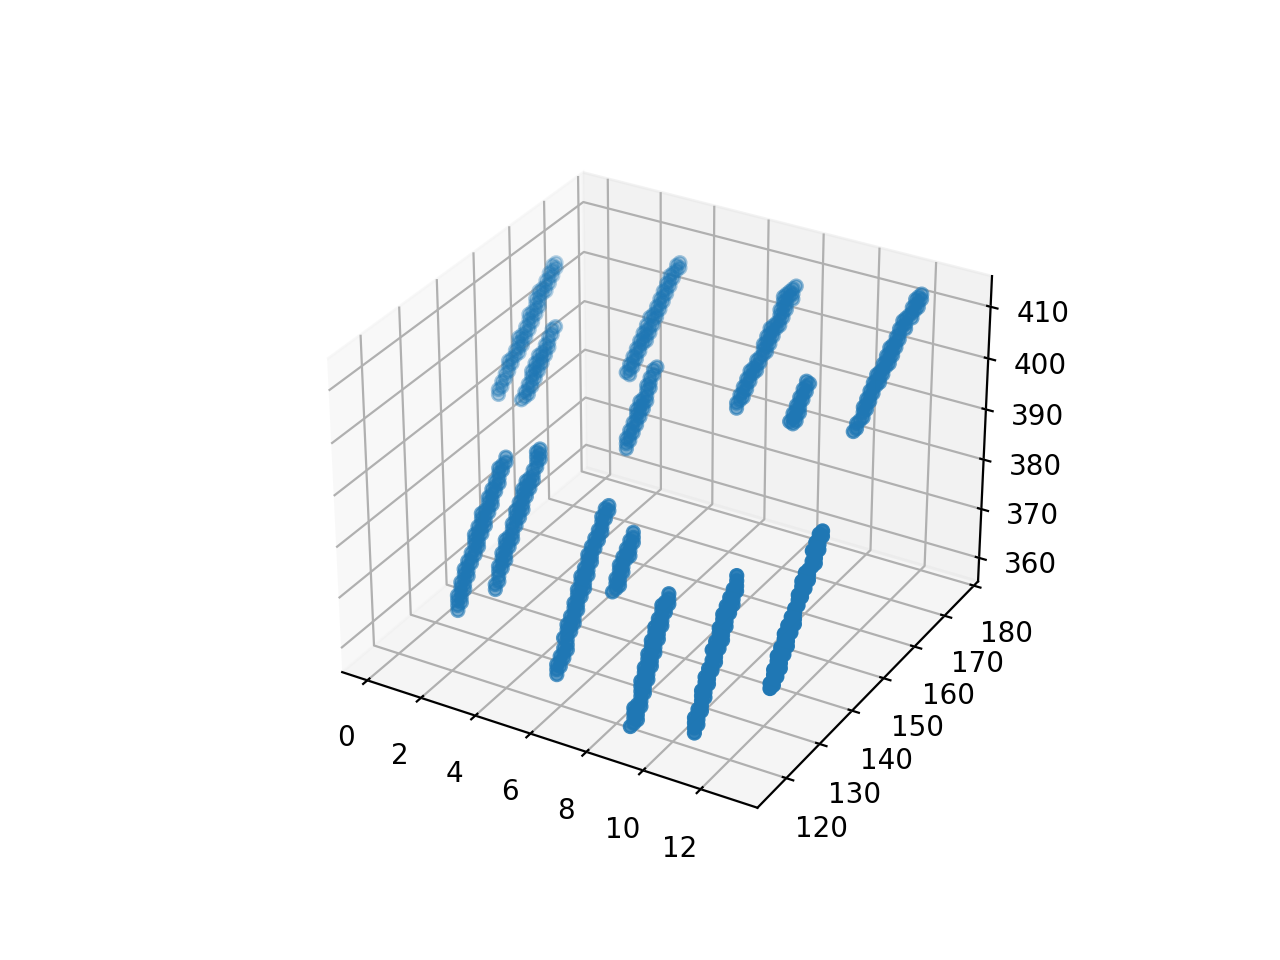

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

all_pts = np.array(all_pts)

ax.scatter(all_pts[:, 0], all_pts[:, 1], all_pts[:, 2] )
# ax.scatter([len(final_groups)] * num_to_consider, cluster_coms[:, 0], cluster_coms[:, 1])

#### Project onto flat, (H, W) plane.

In [30]:
frags = np.zeros_like(slices[0])
# frags.put(all_pts[:, 1:], 1) - not working.
for pt in all_pts:
    frags[pt[1], pt[2]] = -1

#### Apply our hole detection once more!

2 groups found!
255 background pixels found amongst 262144 total pixels.


<IPython.core.display.Javascript object>


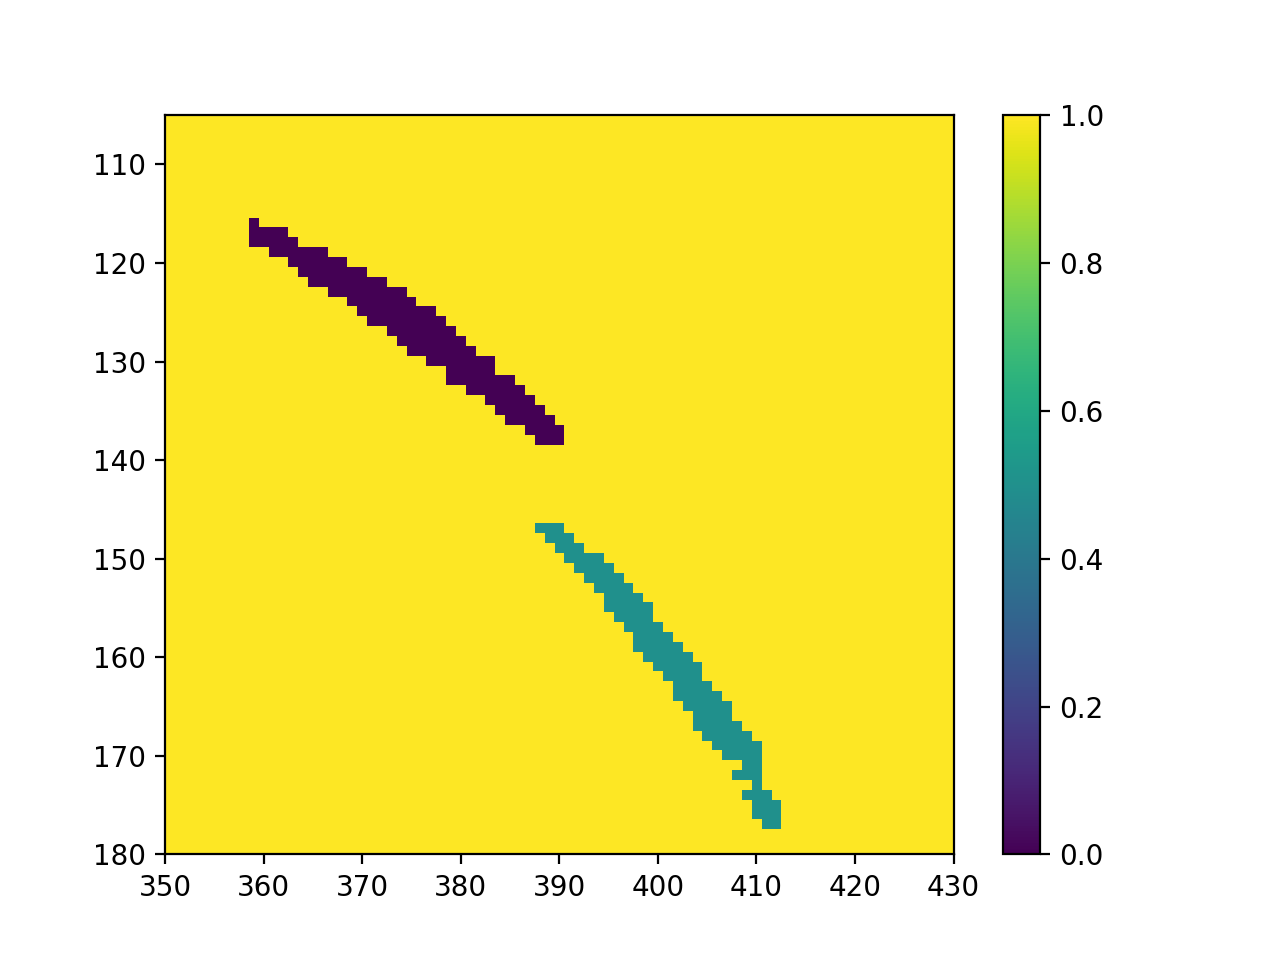

In [31]:
plot_groups(frags)
plt.xlim(350, 430)
_ = plt.ylim(180, 105)

In [57]:
groups, _ = find_groupings(frags)
groups = sorted(groups, key = lambda g : len(g))
# find average width in pixels of each grouping
width = 0
for group in groups:
    temp = np.zeros_like(frags)
    for row, col in group:
        temp[row, col] = 1
    avg_y = temp.sum(axis=0).mean()
    avg_x = temp.sum(axis=1).mean()
    width += np.sqrt(avg_y ** 2 + avg_x ** 2)

width = width / 2
print(width)


0.35217232266126874


### Calculate Percent Displacement!

In [58]:
# calculate farthest pixels away from each other — assume these are the base of each bone fragment.

# find COM of combined group.
tot_r, tot_c, i = 0, 0, 0
for group in groups:
    for row, col in group:
        i += 1
        tot_r += row
        tot_c += col
        
n = len(groups[0]) + len(groups[1])
tot_r /= n
tot_c /= n
com = np.array([tot_r, tot_c])

farthest = np.zeros((2, 2))
n_radius = 5
closest_few = np.zeros((2, n_radius, 2))
for i, group in enumerate(groups):
    g = np.array(group)
    groups[i] = g
    dists = np.abs(g ** 2 - com ** 2).sum(axis=1)
    ind_sort = np.argsort(dists)
    farthest_ind = ind_sort[-1]
    farthest[i] = g[farthest_ind]
    closest_few[i, ...] = g[ind_sort[:n_radius, ...]]
    
closest = closest_few.mean(axis=1)

In [59]:
print(farthest)
print(closest)

[[177. 412.]
 [116. 359.]]
[[147.4 389.2]
 [136.8 387.6]]


#### Will have to re-inspect this implicit coordinate transform

In [71]:
lms = []
for i, group in enumerate(groups):
    lm = LinearRegression(fit_intercept = False)
    g = groups[i]
    g = g - farthest[i]
    lm.fit(g[:, 0].reshape(-1, 1), g[:, 1])
    lms.append(lm)

In [ ]:
base_lm = LinearRegression(fit_intercept = False)
pt = farthest[]
base_lm.fit(farthest[0] - farthest[1])

2 groups found!
255 background pixels found amongst 262144 total pixels.


<IPython.core.display.Javascript object>


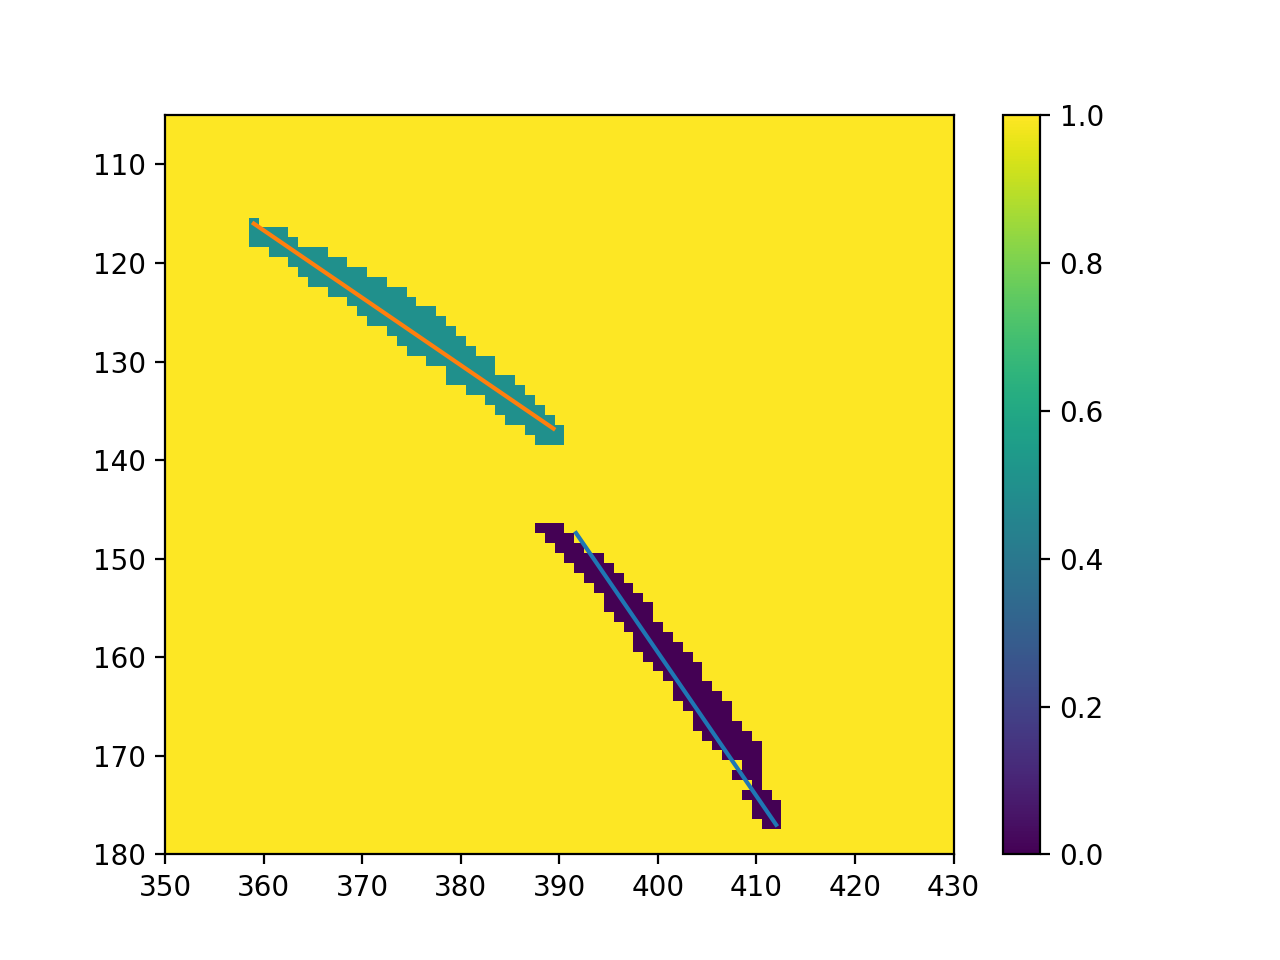

In [110]:
plot_groups(frags)

avg_frag_length = 0
for i in range(2):
    diff = closest[i, 0] - farthest[i, 0]
    avg_frag_length += diff
#     sgn = abs(diff) / diff
#     diff += sgn * 
    mi = min(0, diff)
    ma = max(0, diff)
    preds = lms[i].predict(np.arange(mi, ma, 0.01).reshape(-1,1))

    x_first = np.arange(mi, ma, 0.01) + farthest[i, 0]
    y_first = preds + farthest[i, 1]
    x_first, y_first = y_first, x_first
    plt.plot(x_first, y_first)

plt.xlim(350, 430)
plt.ylim(180, 105)

avg_frag_length /= 2

In [116]:
slope_diff = abs(lms[0].coef_ - lms[1].coef_)
angular_width = width / avg_frag_length
slope_diff -=  angular_width

# Percent Displacement
Units may be slightly off, but this is roughly the % we're looking for!

In [117]:
slope_diff * 100

array([85.57166346])